In [62]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
import pandas as pd
import numpy as np
import pickle

In [2]:
data = pd.read_csv('../data/corona.csv')
display(data.head())

/Users/barn/.envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3,41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
for column in list(data.columns):
    print(column)

CountryName
CountryCode
RegionName
RegionCode
Jurisdiction
Date
C1_School closing
C1_Flag
C2_Workplace closing
C2_Flag
C3_Cancel public events
C3_Flag
C4_Restrictions on gatherings
C4_Flag
C5_Close public transport
C5_Flag
C6_Stay at home requirements
C6_Flag
C7_Restrictions on internal movement
C7_Flag
C8_International travel controls
E1_Income support
E1_Flag
E2_Debt/contract relief
E3_Fiscal measures
E4_International support
H1_Public information campaigns
H1_Flag
H2_Testing policy
H3_Contact tracing
H4_Emergency investment in healthcare
H5_Investment in vaccines
H6_Facial Coverings
H6_Flag
H7_Vaccination policy
H7_Flag
H8_Protection of elderly people
H8_Flag
M1_Wildcard
V1_Vaccine Prioritisation (summary)
V2A_Vaccine Availability (summary)
V2B_Vaccine age eligibility/availability age floor (general population summary)
V2C_Vaccine age eligibility/availability age floor (at risk summary)
V2D_Medically/ clinically vulnerable (Non-elderly)
V2E_Education
V2F_Frontline workers  (non heal

## Notes

If long streak of NaN in between values, drop

In [82]:
RESTRICTION_COLUMNS = [
    "C1_School closing",
    "C2_Workplace closing",
    "C3_Cancel public events",
    "C4_Restrictions on gatherings",
    "C5_Close public transport",
    "C6_Stay at home requirements",
    "C7_Restrictions on internal movement",
    "C8_International travel controls",
    "E1_Income support",
    "E2_Debt/contract relief",
    "E3_Fiscal measures",
    "E4_International support",
    "H1_Public information campaigns",
    "H2_Testing policy",
    "H3_Contact tracing",
    "H4_Emergency investment in healthcare",
    "H5_Investment in vaccines",
    "H6_Facial Coverings",
    "H7_Vaccination policy",
    "H8_Protection of elderly people",
]
FLAG_COLUMNS = [
    "C1_Flag",
    "C2_Flag",
    "C3_Flag",
    "C4_Flag",
    "C5_Flag",
    "C6_Flag",
    "C7_Flag",
    "E1_Flag",
    "H1_Flag",
    "H6_Flag",
    "H7_Flag",
    "H8_Flag",
]
INPUT_COLUMNS = RESTRICTION_COLUMNS + FLAG_COLUMNS
COLUMNS = ["CountryRegion"] + INPUT_COLUMNS + ["ConfirmedCases"]
N_INPUT_DAYS = 7
N_PREDICTION_DAYS = 28
N_DATE_FEATURES_DAYS = N_INPUT_DAYS + N_PREDICTION_DAYS

def get_country_region(data):
    data["CountryRegion"] =  data["CountryName"] + data["RegionName"].fillna("")
    return data

def get_cases_column_names():
    return ["ConfirmedCases{}DaysAgo".format(N_INPUT_DAYS - 1 - i)
            for i in range(N_INPUT_DAYS - 1)
            ]

def pct_change(x):
    return (x.iloc[-1] - x.iloc[0]) / x.iloc[0]

def get_rolling_values(df, column, window):
    return np.lib.stride_tricks.as_strided(df[column],
                                           (len(df) - (window - 1), window),
                                           (df[column].values.strides * 2))

def add_cases_columns(inputdf, window=N_INPUT_DAYS):
    arrays = get_rolling_values(inputdf, "ConfirmedCases", window)
    inputdf.reset_index(inplace=True, drop=True)
    inputdf.loc[window - 1:, get_cases_column_names() + ["ConfirmedCases"]] = arrays
    return inputdf

def cases_columns_to_percentages(inputdf):
    cases_columns = get_cases_column_names() + ["Prediction"]
    for cases_column in cases_columns:
        inputdf.loc[:, cases_column] = inputdf.loc[:, cases_column] / inputdf.loc[:, "ConfirmedCases"]
    return inputdf

def add_prediction_rows(inputdf, window=N_PREDICTION_DAYS):
    arrays = get_rolling_values(inputdf, "ConfirmedCases", window)
    inputdf.reset_index(inplace=True, drop=True)
    inputdf.loc[window - 1:, "Prediction"] = pd.Series(list(arrays))
    inputdf = inputdf.explode("Prediction").iloc[N_PREDICTION_DAYS:]
    inputdf.loc[:, "Prediction"] = inputdf \
        .groupby('CountryRegion')['Prediction'] \
        .transform(lambda x: x.shift(-1))
    inputdf.reset_index(inplace=True)
    inputdf.loc[:, "PredictionWindow"] = inputdf.index + 2 - (inputdf["index"] + 1 - N_PREDICTION_DAYS) * N_PREDICTION_DAYS
    inputdf = cases_columns_to_percentages(inputdf)
    return inputdf.drop(columns=["index", "ConfirmedCases"])

def preprocess_week_change_input(data):
    data = get_country_region(data)
    inputdf = data[COLUMNS]
    inputdf.loc[:, "WeekChangeConfirmedCases"] = inputdf['ConfirmedCases'].rolling(window=7).apply(pct_change)
    inputdf.loc[:, "WeekChangeConfirmedCasesIn3Weeks"] = inputdf \
        .groupby('CountryRegion')['WeekChangeConfirmedCases'] \
        .transform(lambda x: x.shift(-21))
    inputdf.loc[:, INPUT_COLUMNS] = inputdf \
        .groupby('CountryRegion')[INPUT_COLUMNS] \
        .transform(lambda x: x.ffill())
    inputdf.loc[:, FLAG_COLUMNS] = inputdf.loc[:, FLAG_COLUMNS].fillna(1)
    inputdf.loc[:, INPUT_COLUMNS] = inputdf[INPUT_COLUMNS].rolling(window=7).mean()
    inputdf = inputdf[inputdf['ConfirmedCases'] > 1000]
    return inputdf.dropna().reset_index(drop=True)

def preprocess_confirmed_cases_input(data):
    data = get_country_region(data)
    inputdf = data[COLUMNS]
    inputdf = inputdf[inputdf['ConfirmedCases'] > 1000]
    inputdf.loc[:, FLAG_COLUMNS] = inputdf.loc[:, FLAG_COLUMNS].fillna(1)
    inputdf.loc[:, INPUT_COLUMNS] = inputdf.groupby('CountryRegion')[INPUT_COLUMNS].transform(lambda x: x.ffill())
    inputdf = add_cases_columns(inputdf)
    inputdf = add_prediction_rows(inputdf)
    return inputdf.dropna().reset_index(drop=True)

In [40]:
week_change_model = XGBRegressor()
week_change_model.fit(inputdf[INPUT_COLUMNS], inputdf["WeekChangeConfirmedCasesIn3Weeks"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

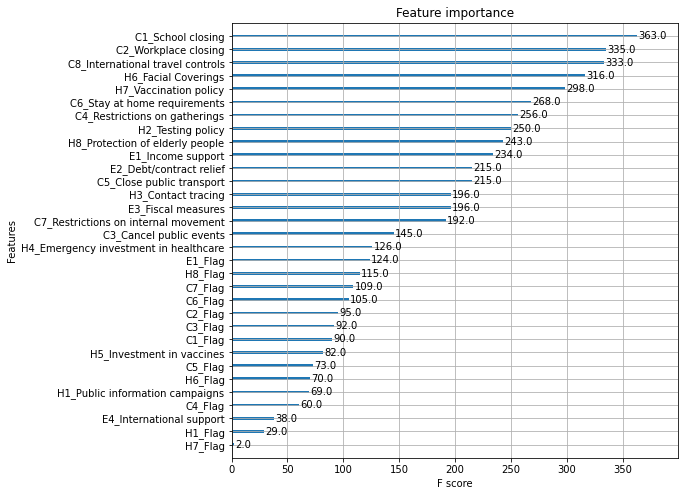

In [41]:
ax = plot_importance(week_change_model)
fig = ax.figure
fig.set_size_inches(8, 8)
pyplot.show()

In [51]:
test_row = pd.DataFrame(columns=INPUT_COLUMNS, dtype=int)
test_row.loc[0] = 0
test_row.loc[0, FLAG_COLUMNS] = 1
predictions = []
for i in range(5):
    test_row.loc[0, "H6_Facial Coverings"] = i
    prediction = week_change_model.predict(test_row)[0]
    predictions.append(prediction)
print(predictions)

[0.61542755, 0.46561402, 0.41057748, 0.39551073, 0.37707648]


In [84]:
confirmed_cases_input = preprocess_confirmed_cases_input(data)
confirmed_cases_model = XGBRegressor()
confirmed_cases_model.fit(confirmed_cases_input[INPUT_COLUMNS + get_cases_column_names() + ["PredictionWindow"]],
                          confirmed_cases_input["Prediction"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

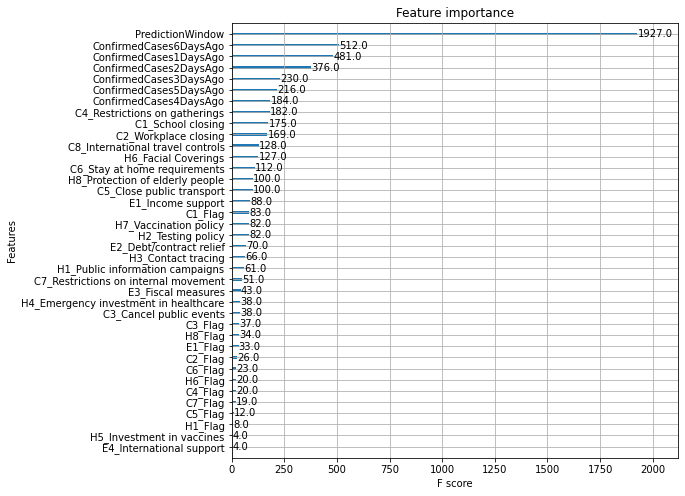

In [85]:
ax = plot_importance(confirmed_cases_model)
fig = ax.figure
fig.set_size_inches(8, 8)
pyplot.show()

In [86]:
# with open('confirmed_cases_model.pkl', 'wb') as f:
#     pickle.dump(confirmed_cases_model, f)
with open('confirmed_cases_model.pkl', 'rb') as f:
    loaded = pickle.load(f)
    print(loaded)

In [83]:
confirmed_cases_input = preprocess_confirmed_cases_input(data)
display(confirmed_cases_input.head(60))

,CountryRegion,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,E1_Income support,...,H7_Flag,H8_Flag,ConfirmedCases6DaysAgo,ConfirmedCases5DaysAgo,ConfirmedCases4DaysAgo,ConfirmedCases3DaysAgo,ConfirmedCases2DaysAgo,ConfirmedCases1DaysAgo,Prediction,PredictionWindow
0,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.05107,2
1,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.055901,3
2,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.087647,4
3,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.148378,5
4,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.167012,6
5,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.193927,7
6,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.193927,8
7,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.225328,9
8,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.23775,10
9,Aruba,2.0,2.0,2.0,4.0,0.0,2.0,0.0,3.0,1.0,...,1.0,1.0,0.837819,0.845066,0.856453,0.893375,0.942029,0.972740,1.264665,11
